# Analysis

- Visualise the processed dataset
- Explore weekly seasonality
- Evaluates a baseline vs a simple linear regression model


In [7]:
#libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Ingest data from processed folder

In [5]:
# data
# Notebooks runs off of machine root and scripts run off of repo root - function to help locate files for each context
def find_repo_root(start: Path) -> Path:
    for parent in [start] + list(start.parents):
        if (parent / "data").exists():
            return parent
    raise FileNotFoundError("Could not locate repo root containing data/")

REPO_ROOT = find_repo_root(Path.cwd().resolve())
PROCESSED_PATH = REPO_ROOT / "data" / "processed" / "processed_c19.csv"
PREDS_PATH = REPO_ROOT / "data" / "processed" / "preds_c19.csv"

In [3]:
df_processed = pd.read_csv(PROCESSED_PATH)
df_processed.head()

,Date,Confirmed,Recovered,Deaths,Increase rate,NewConfirmed,NewDeaths,DayOfWeek,Lag7_NewConfirmed,Lag1_NewConfirmed,TargetNext_NewConfirmed
0,2020-01-22,557,30,17,0.000000,0.0,0.0,2,0.0,0.0,100.0
1,2020-01-23,657,32,18,17.953321,100.0,1.0,3,0.0,0.0,287.0
2,2020-01-24,944,39,26,43.683409,287.0,8.0,4,0.0,100.0,493.0
3,2020-01-25,1437,42,42,52.224576,493.0,16.0,5,0.0,287.0,683.0
4,2020-01-26,2120,56,56,47.529576,683.0,14.0,6,0.0,493.0,809.0


In [6]:
df_preds = pd.read_csv(PREDS_PATH)
df_preds.head()

,Date,y_true,yhat_naive,yhat_model
0,2022-03-17,1913721.0,2223447.0,2.081249e+06
1,2022-03-18,1709103.0,2052909.0,1.842762e+06
2,2022-03-19,1070137.0,1913721.0,1.676932e+06
3,2022-03-20,1470640.0,1709103.0,1.593906e+06
4,2022-03-21,1975436.0,1070137.0,1.363641e+06


# Trend over time 
- Daily new confirmed
- 7 day rolling mean

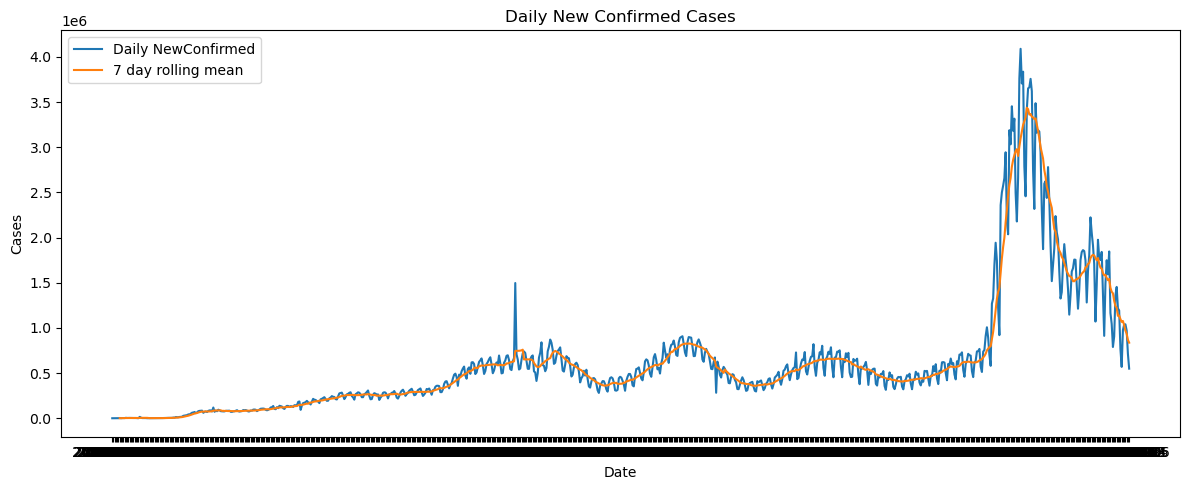

In [9]:
# 7-day rolling mean to smooth reporting noise / weekly effects
df_processed["NewConfirmed_7d"] = df_processed["NewConfirmed"].rolling(7).mean()

plt.figure(figsize=(12, 5))
plt.plot(df_processed["Date"], df_processed["NewConfirmed"], label="Daily NewConfirmed")
plt.plot(df_processed["Date"], df_processed["NewConfirmed_7d"], label="7 day rolling mean")
plt.title("Daily New Confirmed Cases")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.tight_layout()
plt.show()

# Weekly seasonality
- Average NewConfirmed by day of the week

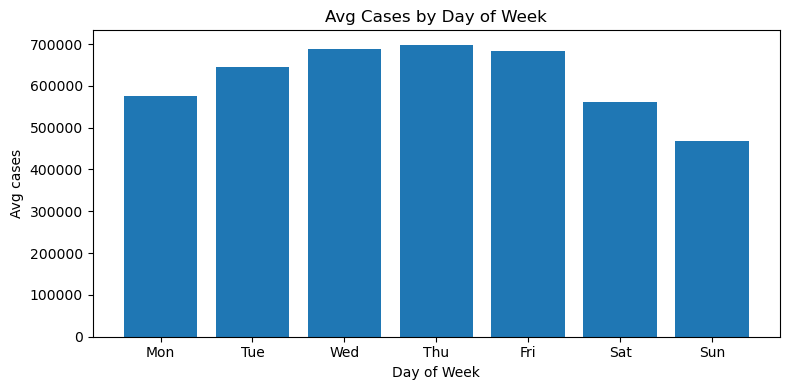

In [11]:
map = {0:"Mon", 1:"Tue", 2:"Wed", 3:"Thu", 4:"Fri", 5:"Sat", 6:"Sun"}

dow_avg = (
    df_processed.groupby("DayOfWeek")["NewConfirmed"]
    .mean()
    .reindex(range(7))
)

plt.figure(figsize=(8, 4))
plt.bar([map[i] for i in dow_avg.index], dow_avg.values)
plt.title("Avg Cases by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Avg cases")
plt.tight_layout()
plt.show()


# Model performance eval
- Actuals vs baseline vs basic linear regression model

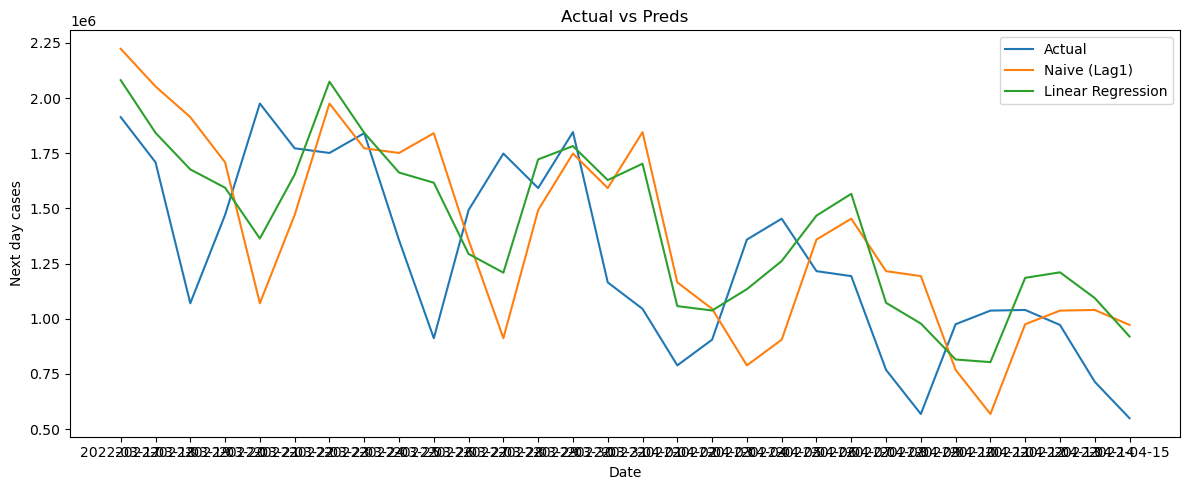

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(df_preds["Date"], df_preds["y_true"], label="Actual")
plt.plot(df_preds["Date"], df_preds["yhat_naive"], label="Naive (Lag1)")
plt.plot(df_preds["Date"], df_preds["yhat_model"], label="Linear Regression")
plt.title("Actual vs Preds")
plt.xlabel("Date")
plt.ylabel("Next day cases")
plt.legend()
plt.tight_layout()
plt.show()

# Error over time
- Absolute error

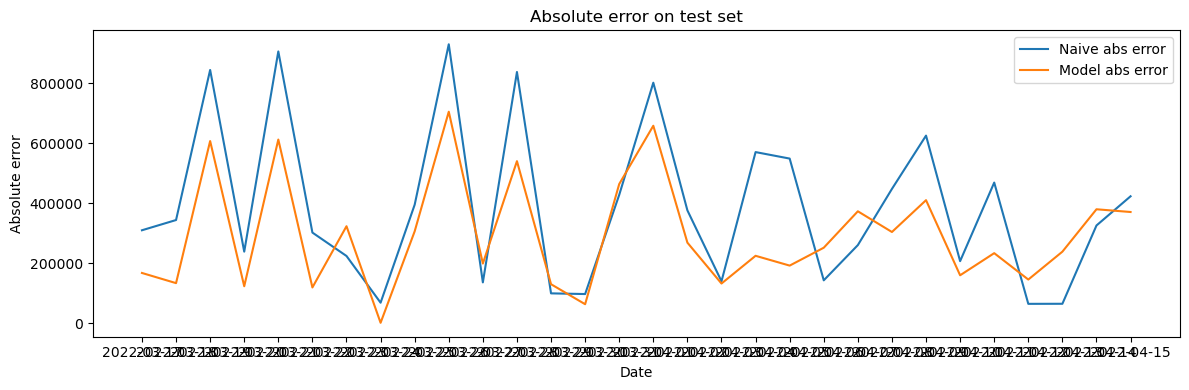

In [14]:
df_preds["abs_err_naive"] = (df_preds["y_true"] - df_preds["yhat_naive"]).abs()
df_preds["abs_err_model"] = (df_preds["y_true"] - df_preds["yhat_model"]).abs()

plt.figure(figsize=(12, 4))
plt.plot(df_preds["Date"], df_preds["abs_err_naive"], label="Naive abs error")
plt.plot(df_preds["Date"], df_preds["abs_err_model"], label="Model abs error")
plt.title("Absolute error on test set")
plt.xlabel("Date")
plt.ylabel("Absolute error")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation summary
- MAE
- RMSE

In [17]:
# MAE
mae_bl = (df_preds["y_true"] - df_preds["yhat_naive"]).abs().mean()
mae_model = (df_preds["y_true"] - df_preds["yhat_model"]).abs().mean()

# RMSE
rmse_naive = np.sqrt(((df_preds["y_true"] - df_preds["yhat_naive"]) ** 2).mean())
rmse_model = np.sqrt(((df_preds["y_true"] - df_preds["yhat_model"]) ** 2).mean())

results = pd.DataFrame({
    "Model": ["Baseline", "Linear Regression"],
    "MAE": [mae_bl, mae_model],
    "RMSE": [rmse_naive, rmse_model],
})

results

,Model,MAE,RMSE
0,Baseline,387383.833333,467317.757438
1,Linear Regression,294493.999602,345986.215115


# Summary:
- Linear regression model provides clear improvement on the baseline:
    - 93k fewer cases of average error per day (24%ish improvement)
    - 121k fewer RMSE (26% improvement)

# Notebook actions:
- load processed + prediction datasets
- plot trend
- visualise weekly seasonality
- compare baseline vs linear regression predictions
- evaluate using MAE and RMSE
- summarise findings